## Problem Statement
Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion
For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.



In [ ]:
# To suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For setting working director
import os
os.chdir(r'/home/xavient/wns_hack')
#os.chdir(r'C:\Users\mohammad shafin\Desktop\wns_hack')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#machine learning libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
import lightgbm as lgb

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, average_precision_score, f1_score, recall_score, roc_auc_score,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import scale

# variables
iter_no = 5
gp_params = {'alpha': 1e-5}
cv_splits = 8
seed = 42


In [2]:
data = pd.read_csv('train.csv')

In [3]:
data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


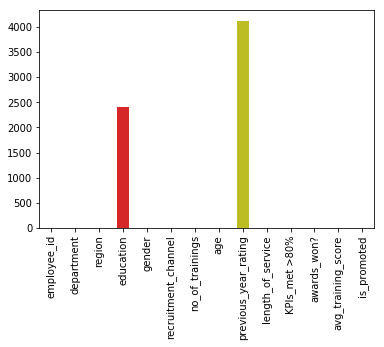

In [4]:
data.isna().sum().plot(kind='bar')
plt.show()

In [5]:

def treesXGBCV(eta, gamma,max_depth,min_child_weight,subsample,colsample_bytree,n_estimators):
    #function for cross validation gradient boosted trees
    return cross_val_score(xgb.XGBRegressor(objective='binary:logistic',
    											tree_method = 'hist',
                                                learning_rate=max(eta,0),
                                                gamma=max(gamma,0),
                                                max_depth=int(max_depth),
                                                min_child_weight=int(min_child_weight),
                                                silent=True,
                                                subsample=max(min(subsample,1),0.0001),
                                                colsample_bytree=max(min(colsample_bytree,1),0.0001),
                                                n_estimators=int(n_estimators),
                                                seed=seed,nthread=-1), 
                           X=X_train, y=y_train, scoring=None, cv=cv_splits, n_jobs=-1).mean()


def treesLGBCV(eta, max_depth,min_child_weight,subsample,colsample_bytree,n_estimators):
    #function for cross validation gradient boosted trees
    return cross_val_score(lgb.LGBMRegressor(objective='binary',
    											boosting_type = 'goss',
                                                learning_rate=max(eta,0),
                                                max_depth=int(max_depth),
                                                min_child_weight=int(min_child_weight),
                                                silent=True,
                                                subsample=max(min(subsample,1),0.0001),
                                                colsample_bytree=max(min(colsample_bytree,1),0.0001),
                                                n_estimators=int(n_estimators),
                                                random_state=seed,nthread=-1), 
                           X=X_train, y=y_train, scoring=None, cv=cv_splits, n_jobs=-1).mean()


def treesRFCV(max_depth,max_leaf_nodes,min_impurity_decrease,n_estimators):
    #function for cross validation gradient boosted trees
    return cross_val_score(RandomForestClassifier(criterion = 'entropy',
                                                max_features =None,
                                                max_depth=int(max_depth),
                                                max_leaf_nodes = int(max_leaf_nodes),
                                                min_impurity_decrease = int(min_impurity_decrease),
                                                n_estimators=int(n_estimators),
                                                random_state=seed,n_jobs=-1), 
                           X=X_train, y=y_train, scoring=None, cv=cv_splits, n_jobs=-1).mean()

In [6]:
def data_prep(data_df):

    #how to handle types
    data_df_num = data_df.select_dtypes(exclude=object)
    data_df_obj = data_df.select_dtypes(include=object)

    #how to handle nan
    data_df_num = data_df_num.fillna(data_df_num.mean())
    for column in data_df_num.columns:
        data_df_num[column] = scale(data_df_num[column])
    #get dummy variables
    data_df_obj = data_df_obj.fillna("UNKNOWN")
    data_df_obj = pd.get_dummies(data_df_obj, dummy_na=True)

    data_concat = pd.concat([data_df_num, data_df_obj],axis=1)

    return data_concat.drop(['department_nan','department_R&D','department_Finance','department_Operations',
                             'education_nan','education_Below Secondary',
                             'region_region_18','region_nan','region_region_10','region_region_12','region_region_24',
                             'region_region_31', 'region_region_33','region_region_1','region_region_13','region_region_14',
                             'region_region_15','region_region_27','region_region_30','region_region_8','region_region_3',
                             'recruitment_channel_sourcing','recruitment_channel_other','recruitment_channel_nan',
                             'gender_m','gender_nan','region_region_21','region_region_6', 'region_region_5'],axis=1) 

In [7]:
def data_split(df):
    
    # Create a data split of train, test and original
    train = df.sample(frac=.70,random_state=seed)
    test = df[-df.employee_id.isin(train.employee_id)]
    train = train.set_index('employee_id')
    test = test.set_index('employee_id')
    df = df.set_index('employee_id')
    return train, test, df

In [8]:

# reading data
data_train = pd.read_csv('train.csv', sep=',',encoding="ISO-8859-1")
data_train['is_promoted'] = data_train['is_promoted'].astype('object')
data_train, data_test, data = data_split(data_train)
data_train = data_prep(data_train)
data_test = data_prep(data_test)

#data_pred = pd.read_csv('test.csv', sep=',',encoding="ISO-8859-1")
#data_pred = data_pred.set_index("employee_id")
#data_pred = data_prep(data_pred)




In [9]:
data_train.shape, data_test.shape, data.shape

((38366, 36), (16442, 36), (54808, 13))

In [25]:
#train test split doesnt actually split
X_train, X_test, y_train, y_test = train_test_split(np.array(data_train.drop(['is_promoted'],axis=1)), np.array(data_train['is_promoted']), test_size=0, random_state=42)
X_test1 = np.array(data_test.drop('is_promoted', axis=1))
y_test1 = np.array(data_test['is_promoted'])

In [11]:
#Bayesian Hyper parameter optimization of gradient boosted trees
treesBO_XGB = BayesianOptimization(treesXGBCV,{'eta':(0.10,0.12),
                                        'gamma':(10,13),
                                        'max_depth':(540,580),
                                        'min_child_weight':(0.5,0.7),
                                        'subsample':(0.4,0.7),
                                        'colsample_bytree':(0.5,0.6),
                                        'n_estimators':(200,1800)})
treesBO_XGB.maximize(n_iter=iter_no, **gp_params)
treeXGB_best = treesBO_XGB.res['max']

Initialization
--------------------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |       eta |     gamma |   max_depth |   min_child_weight |   n_estimators |   subsample | 
    1 | 00m34s |    0.37259 |             0.5125 |    0.1199 |   12.1762 |    541.7175 |             0.5313 |       779.4823 |      0.5460 | 
    2 | 01m11s |    0.37538 |             0.5113 |    0.1176 |   11.9622 |    575.9374 |             0.6588 |      1647.4624 |      0.5747 | 
    3 | 00m35s |    0.37552 |             0.5930 |    0.1169 |   10.4140 |    560.3918 |             0.5645 |       646.3457 |      0.5718 | 
    4 | 00m23s |    0.37392 |             0.5358 |    0.1092 |   10.1873 |    570.2750 |             0.5903 |       526.7525 |      0.5069 | 
    5 | 00m59s |    0.37506 |             0.5761 |    0.1081 |   10.0460 |    579.1831 |             0.5866 |      1363.4574 |      0.

In [67]:
#Bayesian Hyper parameter optimization of gradient boosted trees
treesBO_LGB = BayesianOptimization(treesLGBCV,{'eta':(0.10,0.12),
                                        'max_depth':(540,580),
                                        'min_child_weight':(0.5,0.7),
                                        'subsample':(0.4,0.7),
                                        'colsample_bytree':(0.5,0.6),
                                        'n_estimators':(100,1800)})
treesBO_LGB.maximize(n_iter=iter_no, **gp_params)
treeLGB_best = treesBO_LGB.res['max']

Initialization
--------------------------------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   colsample_bytree |       eta |   max_depth |   min_child_weight |   n_estimators |   subsample | 
    1 | 00m05s |    0.31646 |             0.5490 |    0.1159 |    553.5303 |             0.5789 |       747.6369 |      0.4181 | 
    2 | 00m02s |    0.35937 |             0.5398 |    0.1152 |    564.1951 |             0.5877 |       211.6239 |      0.5301 | 
    3 | 00m03s |    0.34578 |             0.5625 |    0.1072 |    555.0954 |             0.6534 |       413.2383 |      0.6482 | 
    4 | 00m09s |    0.27492 |             0.5559 |    0.1134 |    557.3951 |             0.5041 |      1389.1686 |      0.6748 | 
    5 | 00m01s |    0.36478 |             0.5402 |    0.1110 |    559.0544 |             0.5004 |       110.6704 |      0.6528 | 
Bayesian Optimization
------------------------------------------------------

In [15]:
#Bayesian Hyper parameter optimization of gradient boosted trees
treesBO_RF = BayesianOptimization(treesRFCV,{'max_depth':(50,600),
                                        'max_leaf_nodes':(50,600),
                                        'min_impurity_decrease':(0,10),
                                        'n_estimators':(100,1800)})
treesBO_RF.maximize(n_iter=iter_no, **gp_params)
treeRF_best = treesBO_RF.res['max']

Initialization
---------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_leaf_nodes |   min_impurity_decrease |   n_estimators | 
    1 | 00m05s |    0.91623 |    500.8975 |         593.4298 |                  9.6670 |       274.7630 | 
    2 | 00m32s |    0.91623 |    311.2875 |         115.3406 |                  5.2241 |      1722.5184 | 
    3 | 00m15s |    0.91623 |    367.9809 |         130.6525 |                  5.5887 |       824.5636 | 
    4 | 00m29s |    0.91623 |    586.1954 |         126.1869 |                  2.6158 |      1603.7688 | 
    5 | 00m16s |    0.91623 |    113.1023 |         501.7729 |                  9.9933 |       857.5034 | 
Bayesian Optimization
---------------------------------------------------------------------------------------------------------
 Step |   Time |      Value |   max_depth |   max_leaf_nodes |   min_impurity_decrease |   n_estimators | 
  

In [26]:
#train tree with best param for XGB
trees_model_xgb = xgb.XGBRegressor(objective='binary:logistic',
                                tree_method = 'hist',
                                seed=42,
                                learning_rate=max(treeXGB_best['max_params']['eta'],0),
                                gamma=max(treeXGB_best['max_params']['gamma'],0),
                                max_depth=int(treeXGB_best['max_params']['max_depth']),
                                min_child_weight=int(treeXGB_best['max_params']['min_child_weight']),
                                silent=True,
                                subsample=max(min(treeXGB_best['max_params']['subsample'],1),0.0001),
                                colsample_bytree=max(min(treeXGB_best['max_params']['colsample_bytree'],1),0.0001),
                                n_estimators=int(treeXGB_best['max_params']['n_estimators']),nthread=-1)
trees_model_xgb.fit(X_train, y_train)
y_hat1 = trees_model_xgb.predict(np.array(X_test1))

In [45]:
#train tree with best paras for LGB
trees_model_lgb = lgb.LGBMRegressor(objective='binary',
                                boosting_type = 'goss',
                                random_state=42,
                                learning_rate=max(treeLGB_best['max_params']['eta'],0),
                                max_depth=int(treeLGB_best['max_params']['max_depth']),
                                min_child_weight=int(treeLGB_best['max_params']['min_child_weight']),
                                silent=True,
                                subsample=max(min(treeLGB_best['max_params']['subsample'],1),0.0001),
                                colsample_bytree=max(min(treeLGB_best['max_params']['colsample_bytree'],1),0.0001),
                                n_estimators=int(treeLGB_best['max_params']['n_estimators']),nthread=-1)
trees_model_lgb.fit(X_train, y_train)
y_hat2 = trees_model_lgb.predict(np.array(X_test1))

In [30]:
#train tree with best paras for RF
trees_model_rf = RandomForestClassifier(criterion='entropy',
                                max_features = None,
                                max_depth=int(treeRF_best['max_params']['max_depth']),
                                max_leaf_nodes=int(treeRF_best['max_params']['max_leaf_nodes']),
                                min_impurity_decrease=int(treeRF_best['max_params']['min_impurity_decrease']),
                                random_state=seed,
                                n_estimators=int(treeRF_best['max_params']['n_estimators']),n_jobs=-1)
trees_model_rf.fit(X_train, y_train)
y_hat3 = trees_model_rf.predict_proba(np.array(X_test1))

In [50]:
X1_train, X1_test, y1_train, y1_test = train_test_split(np.array(data_train.drop(['is_promoted'],axis=1)),
                                                        np.array(data_train['is_promoted']), test_size=0.2, random_state=seed)

def run_lgb(train_X, train_y, val_X, val_y):
    params = {
    "objective" : "binary",
    "metric" : "auc",
    "num_leaves" : 40,
    "learning_rate" : 0.005,
    "bagging_fraction" : 0.6,
    "feature_fraction" : 0.6,
    "bagging_frequency" : 6,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "seed": seed
    }

    lgtrain = lgb.Dataset(train_X, label = train_y)
    lgval = lgb.Dataset(val_X, label = val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets = [lgtrain, lgval], early_stopping_rounds = 100, 
                  verbose_eval = 150, evals_result = evals_result)
    return model, evals_result
    
print("LGBM performance without BO")
model_lgbm, evals_result = run_lgb(X1_train, y1_train, X1_test, y1_test)


LGBM performance without BO
Training until validation scores don't improve for 100 rounds.
[150]	training's auc: 0.917452	valid_1's auc: 0.895011
[300]	training's auc: 0.923131	valid_1's auc: 0.897115
[450]	training's auc: 0.927437	valid_1's auc: 0.898767
[600]	training's auc: 0.932053	valid_1's auc: 0.900915
[750]	training's auc: 0.935492	valid_1's auc: 0.901874
[900]	training's auc: 0.938547	valid_1's auc: 0.902352
[1050]	training's auc: 0.941421	valid_1's auc: 0.903056
[1200]	training's auc: 0.94392	valid_1's auc: 0.903868
[1350]	training's auc: 0.946296	valid_1's auc: 0.90428
[1500]	training's auc: 0.948644	valid_1's auc: 0.904287
Early stopping, best iteration is:
[1416]	training's auc: 0.947243	valid_1's auc: 0.904382


In [51]:
y_hatx = model_lgbm.predict(np.array(X_test1))

In [ ]:
confusion_matrix(y_test1,np.where(y_hatx>.5,1,0))

In [66]:
confusion_matrix(y_test1,np.where(rf_smote_accuracy[:,1]>.5,1,0))

array([[14928,    60],
       [ 1057,   397]])

In [63]:
roc_auc_score(y_test1,y_hatx)

0.9087707350658152

In [40]:
confusion_matrix(y_test1,np.where(y_hat1>.5,1,0))

array([[14965,    23],
       [ 1003,   451]])

In [46]:
confusion_matrix(y_test1,np.where(y_hat2>.5,1,0))

array([[14782,   206],
       [  913,   541]])

In [41]:
confusion_matrix(y_test1,np.where(y_hat3[:,1]>.5,1,0))

array([[14927,    61],
       [  968,   486]])

In [62]:
roc_auc_score(y_test1,y_hat1), roc_auc_score(y_test1,y_hat2), roc_auc_score(y_test1,y_hat3[:,1]), roc_auc_score(y_test1,rf_smote_accuracy[:,1])

(0.9068077708384039, 0.8942785360796659, 0.903998875395594, 0.8861791863568801)

In [ ]:
#yhat=np.where(y_hat1>=.5,1,0)

In [ ]:
#train test split doesnt actually split
X_train, X_test, y_train, y_test = train_test_split(np.array(data_train.drop(['is_promoted'],axis=1)), np.array(data_train['is_promoted']), test_size=0.2, random_state=42)
X_test1 = data_pred

In [ ]:
#'''
def run_lgb(train_X, train_y, val_X, val_y):
    params = {
    "objective" : "binary",
    "metric" : "auc",
    "num_leaves" : 40,
    "learning_rate" : 0.005,
    "bagging_fraction" : 0.6,
    "feature_fraction" : 0.6,
    "bagging_frequency" : 6,
    "bagging_seed" : 42,
    "verbosity" : -1,
    "seed": 42
    }

    lgtrain = lgb.Dataset(train_X, label = train_y)
    lgval = lgb.Dataset(val_X, label = val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 5000, valid_sets = [lgtrain, lgval], early_stopping_rounds = 100, 
              verbose_eval = 150, evals_result = evals_result)
    return model, evals_result
#'''

In [ ]:

#print("LGBM performance")
model_lgbm, evals_result = run_lgb(X_train, y_train, X_test, y_test)

print("LightGBM Training Completed...")
#print("################################################")
y_hat2 = model_lgbm.predict(np.array(X_test1))


In [ ]:
'''
cb_model = CatBoostClassifier(iterations=500,
                            # objective = 'binary',
                             learning_rate=0.05,
                             depth=10,
                             eval_metric='AUC',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
'''

In [ ]:
#cb_model.fit(X_train, y_train,
#             eval_set=(X_test, y_test),
#             use_best_model=True,
#             verbose=True)
#pred_test_cat = (cb_model.predict_proba(np.array(X_test1)))

In [ ]:
yhats = y_hat1 + y_hat2

In [ ]:
#yhats = (pred_test_xgb*.5+y_hat2*.3+pred_test_cat[:,1])

In [ ]:
yhat = np.where(yhats>.5,1,0)

In [ ]:

submission = pd.DataFrame({'employee_id':np.array(data_pred.reset_index("employee_id")['employee_id']),'is_promoted':yhat})

#write to file for submission
submission.to_csv('submission.csv',sep=',', index=False)

In [ ]:
submission.head()

In [ ]:
trees_model.feature_importances_

In [ ]:
submission.is_promoted.value_counts()

In [54]:
# import ensemble models

from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

# First create the base model to tune

rf = RandomForestClassifier()

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
random_state = [42]

# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state':random_state}



In [55]:
#pprint(random_grid)

# Random search of parameters, using 10 fold cross validation,
# search across 50 different combinations, and use all available cores
rf_smote = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
rf_smote.fit(X1_train, y1_train)

# Random search of parameters, using 10 fold cross validation,
# search across 50 different combinations, and use all available cores
#rf_smote2 = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5, cv = 3, verbose=0, random_state=42, n_jobs = -1)
# Fit the random search model
#rf_smote2.fit(training_features2, training_target2)

# Check accuracy on test set


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=-1,
          param_distributions={'random_state': [42], 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'bootstrap': [True, False], 'min_samples_leaf': [1, 2, 4], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'max_features': ['auto', 'sqrt']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [60]:
rf_smote_accuracy = rf_smote.predict_proba(X_test1)

In [61]:
rf_smote_accuracy

array([[1.        , 0.        ],
       [0.99555357, 0.00444643],
       [0.87972302, 0.12027698],
       ...,
       [0.99090833, 0.00909167],
       [1.        , 0.        ],
       [0.92201786, 0.07798214]])